In [30]:
#############
# Libraries #
#############

using CSV, DataFrames, DataFramesMeta, Missings, CategoricalArrays
using StatsBase, Statistics, HypothesisTests, MatrixLM
using Random, Distributions, StatsModels
using LinearAlgebra
using FreqTables, Plots, StatsPlots
using ColorSchemes, RecipesBase 
using SpecialFunctions

In [31]:
#######################
# Plotting attributes #
#######################
myfont = "Helvetica"
mytitlefontsize = 12 

12

In [32]:
######################
# External functions #
######################
include(joinpath(@__DIR__, "..","src","wrangle_utils.jl" ));
include(joinpath(@__DIR__, "..","src","utils.jl" ));
include(joinpath(@__DIR__, "..","src","utils_copd_spiro.jl" ));
include(joinpath(@__DIR__, "..","src","demog.jl" ));
include(joinpath(@__DIR__, "..","src","mLinearModel.jl" ));
include(joinpath(@__DIR__,"..", "src","myPlots.jl" ));
	

In [33]:
copd =  get_data("COPDGene")

CohortData(784×14 DataFrame
 Row │ SampleName  SampleID    Site     FinalGold  Sex      Age      BMI       ⋯
     │ String7     String15    String3  Int64      String7  Float64  Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 10010J      NJHC-00611  NJC              2  Female      73.5    27.51   ⋯
   2 │ 10031R      NJHC-00004  NJC              2  Male        66.3    22.77
   3 │ 10032T      NJHC-00006  NJC              2  Female      66.3    31.78
   4 │ 10052Z      NJHC-00708  NJC              4  Male        55.1    26.08
   5 │ 10055F      NJHC-01099  NJC              0  Male        75.8    26.95   ⋯
   6 │ 10056H      NJHC-00003  NJC              4  Female      54.1    37.43
   7 │ 10057J      NJHC-00002  NJC              3  Male        62.2    24.53
   8 │ 10060Y      NJHC-00074  NJC              2  Male        78.5    28.9
   9 │ 10072F      NJHC-00001  NJC              2  Female      75.3    27.62   ⋯
  10 │ 10077P      NJHC-0

In [37]:
fileClinicalDict = joinpath(@__DIR__,"..","data","processed","COPDGene",
                            "ClinicalDataDictionary.csv");
dfClinicalDict = CSV.read(fileClinicalDict, DataFrame);

In [38]:
#################################
# Choose predictors for X matrix
#################################
xCovariates = ["Intercept", "Sex", "Age", "BMI",
                "SmokingPackYears", "PercentEmphysema",
                "COPD", "NHW", "CurrentSmoker"]

# Build the predictor string
vPredictorNames = copy(xCovariates)
# Rename "Intercept" -> "1" before building the @formula
for i in eachindex(vPredictorNames)
    if vPredictorNames[i] == "Intercept"
        vPredictorNames[i] = "1"
    end
end
frml = join(vPredictorNames, " + ")

# Append "+ Site" (site-adjusted X)
frml_site_adjusted = frml * " + Site"

# formulaX == @formula(0 ~ <frml_site_adjusted>).rhs
formulaX = eval(Meta.parse(string("@formula(0 ~ ", frml_site_adjusted, ").rhs")))

#########################################
# Contrasts for categorical variables
#########################################
contrasts_copd = Dict(
    :Sex           => EffectsCoding(base = sort(unique(copd.dfInd.Sex))[2]),
    :NHW           => EffectsCoding(base = sort(unique(copd.dfInd.NHW))[1]),
    :Site          => EffectsCoding(base = sort(unique(copd.dfInd.Site))[1]),
    :CurrentSmoker => EffectsCoding(base = sort(unique(copd.dfInd.CurrentSmoker))[1]),
    :COPD          => EffectsCoding(base = sort(unique(copd.dfInd.COPD))[1]),
)

##################
# Build X matrix
##################
mXcopd  = modelmatrix(formulaX,  copd.dfInd;  hints = contrasts_copd)

784×10 Matrix{Float64}:
 1.0   1.0  73.5  27.51  30.7   2.42326    1.0   1.0  -1.0  -1.0
 1.0  -1.0  66.3  22.77  46.9  34.7749     1.0   1.0  -1.0  -1.0
 1.0   1.0  66.3  31.78  40.0   6.45937    1.0   1.0  -1.0  -1.0
 1.0  -1.0  55.1  26.08  39.5   4.27442    1.0   1.0   1.0  -1.0
 1.0  -1.0  75.8  26.95  20.0   1.51622   -1.0  -1.0  -1.0  -1.0
 1.0   1.0  54.1  37.43  72.0  21.8802     1.0   1.0  -1.0  -1.0
 1.0  -1.0  62.2  24.53  40.3  11.1913     1.0   1.0   1.0  -1.0
 1.0  -1.0  78.5  28.9   81.0  27.7891     1.0   1.0  -1.0  -1.0
 1.0   1.0  75.3  27.62  96.0   1.67065    1.0   1.0  -1.0  -1.0
 1.0   1.0  67.8  23.72  72.0   5.78305    1.0   1.0  -1.0  -1.0
 1.0  -1.0  56.2  37.06  68.4   1.89047    1.0   1.0   1.0  -1.0
 1.0  -1.0  54.5  39.41  31.8   3.56222   -1.0   1.0   1.0  -1.0
 1.0  -1.0  76.8  28.01  62.0   4.9056     1.0   1.0   1.0  -1.0
 ⋮                              ⋮                           
 1.0  -1.0  54.6  20.97  52.1   1.14824   -1.0  -1.0   1.0  -1.0
 1.0 

In [39]:
###########################
# Coefficient-name vectors
###########################
# Full coefficient names
sch_copd  = schema(formulaX,  copd.dfInd,  contrasts_copd)
vFrmlNames_copd  = coefnames(apply_schema(formulaX,  sch_copd))

# "pseudo" names: remove parens, replace ": " with "_", and " & " with "Ξ"
fix_covar_name(s::String) = replace(replace(replace(s, "("=>"", ")"=>""), ": "=>"_"), " & "=>"Ξ")
vPseudoFrmlNames_copd  = fix_covar_name.(vFrmlNames_copd)

# Indices of covariates (non-Site columns)
idx_covar_copd  = findall(.!occursin.("Site", vFrmlNames_copd))


9-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
 7
 8
 9

In [40]:
# Define Z as an identity matrix (no grouping)
mZ_id_copd = Matrix{Float64}(I, size(copd.mY, 2), size(copd.mY, 2))

999×999 Matrix{Float64}:
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [41]:
# Center COPD Y
Y_copd_centered = copd.mY .- mean(copd.mY; dims=1)

784×999 Matrix{Float64}:
  0.728162   -1.06166      0.521195   …  -0.216604   -0.351333    0.15616
  1.2142     -0.329079     0.17308        1.06625    -0.269919   -0.274296
  0.439633    0.817412    -0.531919      -0.244868   -0.203986   -0.488162
 -1.32416    -0.859182    -1.05515       -0.534012    0.73783     1.16527
  0.879904   -0.747748     2.10626        1.67352     2.16807     0.621652
  1.57041     0.013876     3.62777    …   4.57287    -0.0811238  -0.123824
 -1.18335     1.82516     -0.586831      -0.732048   -0.0968187   0.598783
 -1.03611     1.15481     -1.09194       -0.594452   -0.47619     0.125594
 -1.3051     -0.164123    -1.11712       -0.810295   -0.276888    1.45895
 -1.33534    -0.0770829    1.04624       -0.849367    0.463885    0.787756
 -1.12772    -0.829702    -1.14987    …  -0.521503    0.607445    1.29849
 -0.218956    2.3374      -0.162038       0.681653    1.17479     1.37088
 -0.233852    0.0919344   -0.691715      -0.302834   -1.58415    -1.03996
  ⋮   

In [42]:
# ---------------------------------------------------------
# Coefficients via MatrixLM (with shrinkage targetType="B")
# ---------------------------------------------------------
copdZsp = mlm(RawData(Response(Y_copd_centered), Predictors(mXcopd, mZ_id_copd)), addXIntercept=false, addZIntercept=false, targetType="B")

Mlm([-0.7246672321502756 0.4100078326979901 … 1.7590576295449487 -0.07982326090279461; 0.17677335037020106 -0.027974497058152237 … 0.23474632172756935 -0.032099228549337416; … ; 0.013357883977949042 -0.09949415320794394 … 0.05084305178354425 -0.027041877894793294; 0.032336656550099506 0.066317607016986 … -0.02498552651109575 0.0685161455613734], [0.14169402926886213 0.14320708314042563 … 0.12985430854567895 0.14187089696754182; 0.0013031501438501372 0.0013170655951966412 … 0.001194261054852001 0.0013047767837880808; … ; 0.002308519866393604 0.002333170975120284 … 0.0021156237320747897 0.0023114014457955886; 0.0015493453097701639 0.0015658897113333963 … 0.0014198845564405696 0.0015512792595689887], [0.9530840160693941 -0.1428783560911092 … 0.06507058962531373 -0.2649615363494951; -0.1428783560911092 0.9632613500606716 … -0.13230720214791358 -0.01889494599025741; … ; 0.06507058962531373 -0.13230720214791358 … 0.8734458786389185 0.09492682140571317; -0.2649615363494951 -0.0188949459902574

In [43]:
copdZsp_coef = MatrixLM.coef(copdZsp)

10×999 Matrix{Float64}:
 -0.724667      0.410008     0.318996     …   1.75906      -0.0798233
  0.176773     -0.0279745    0.177357         0.234746     -0.0320992
  0.00214989   -6.02583e-5  -0.00711489      -0.0201375    -0.00903296
  0.0154757    -0.00578722   0.0073861       -0.0155107     0.0217882
  0.000326729  -0.00461934  -0.000274101      0.000654169   0.00237953
  0.0142818    -0.00941846   0.0122684    …   0.00341233   -0.00486986
 -0.051207      0.152133     0.0221126       -0.106463     -0.02899
  0.0272188     0.024964    -0.135783         0.00414289   -0.0151373
  0.0133579    -0.0994942   -0.038814         0.0508431    -0.0270419
  0.0323367     0.0663176    0.142042        -0.0249855     0.0685161

In [44]:
copdZsp_tstat = MatrixLM.t_stat(copdZsp)

10×999 Matrix{Float64}:
 -1.92514    1.08345     0.852406  …   0.923068    4.88148    -0.211925
  4.89688   -0.77083     4.94184       3.4803      6.79281    -0.888641
  0.453217  -0.0126357  -1.50867      -1.49377    -4.43448    -1.90304
  2.50354   -0.931253    1.20187       0.731386   -2.6211      3.52253
  0.201     -2.82672    -0.169612      0.812447    0.420384    1.46295
  3.32951   -2.18408     2.87688   …   1.16946     0.830989   -1.1346
 -1.08934    3.21923     0.473165      0.928548   -2.36582    -0.616329
  0.403459   0.368076   -2.02448      -2.07553     0.0641479  -0.224238
  0.278017  -2.0598     -0.812566     -0.963513    1.10538    -0.56247
  0.821525   1.6759      3.62978       0.0198742  -0.663074    1.73959

In [45]:
copdZsp_se = abs.(copdZsp_coef ./ copdZsp_tstat)

10×999 Matrix{Float64}:
 0.376423    0.378427    0.37423     …  0.379106    0.360353    0.376658
 0.0360992   0.0362914   0.0358889      0.0363565   0.0345581   0.0361217
 0.00474363  0.00476889  0.004716       0.00477744  0.00454113  0.00474659
 0.00618153  0.00621444  0.00614552     0.00622559  0.00591764  0.00618538
 0.00162552  0.00163417  0.00161605     0.0016371   0.00155612  0.00162653
 0.00428947  0.00431231  0.00426449  …  0.00432004  0.00410635  0.00429215
 0.0470072   0.0472575   0.0467334      0.0473423   0.0450005   0.0470366
 0.0674635   0.0678228   0.0670706      0.0679444   0.0645835   0.0675056
 0.0480471   0.0483029   0.0477672      0.0483895   0.0459959   0.048077
 0.0393617   0.0395713   0.0391325      0.0396423   0.0376814   0.0393863

In [46]:
# Factorize superclasses and subclasses
# convert to categorical to get integer codes
copd.dfRef.SuperClassID = categorical(copd.dfRef.SuperClassID)
copd.dfRef.SubClassID   = categorical(copd.dfRef.SubClassID)

# integer codes (1-based)
superclass_of_met = levelcode.(copd.dfRef.SuperClassID)
subclass_of_met   = levelcode.(copd.dfRef.SubClassID)

G = length(levels(copd.dfRef.SuperClassID))  # number of superclasses
H = length(levels(copd.dfRef.SubClassID))    # number of subclasses

106

In [47]:
# Map subclasses to their superclasses
# For each subclass level, find its parent superclass code
super_of_sub = similar(1:H)
for (h, sublev) in enumerate(levels(copd.dfRef.SubClassID))
    # look up the first metabolite with this subclass and get its superclass code
    idx = findfirst(==(sublev), copd.dfRef.SubClassID)
    super_of_sub[h] = superclass_of_met[idx]
end

In [48]:
# Helper functions for Gibbs sampler

# Half-Cauchy(0, s) via truncation
half_cauchy(s) = truncated(Cauchy(0.0, s), 0.0, Inf)

# Normal update from precision parameters
@inline function normal_update_from_prec(lik_prec, lik_sum, prior_prec, prior_mean)
    post_prec = lik_prec + prior_prec
    post_mean = (lik_sum + prior_prec * prior_mean) / post_prec
    post_var  = 1.0 / post_prec
    return post_mean, post_var
end

# Inverse Gamma update
@inline ig_sample(shape, scale) = rand(InverseGamma(shape, scale))

ig_sample (generic function with 1 method)

In [50]:
# Gibbs Sampler for One level of hierarchy

function gibbs_meta_hier_traces_db(
    b_obs::Vector{Float64},           # length m
    se_obs::Vector{Float64},          # length m
    subclass_of_met::Vector{Int},     # length m, values in 1..H (Total DB class)
    H::Int;                           # number of DB categories
    mu0::Float64 = 0.0,
    s0::Float64 = 1.0,
    halfcauchy_scale::Float64 = 1.0,
    n_iter::Int = 2000,
    burnin::Int = 500,
    thin::Int = 1,
    seed::Int = 1234,
)
    @assert length(b_obs) == length(se_obs) "b_obs and se_obs must have same length"
    @assert length(subclass_of_met) == length(b_obs) "subclass_of_met must have length m"
    @assert maximum(subclass_of_met) == H "subclass_of_met must be in 1..H"
    @assert burnin < n_iter "burnin must be < n_iter"
    @assert thin ≥ 1

    Random.seed!(seed)
    m = length(b_obs)
    lam_j = 1.0 ./ (se_obs .^ 2)  # observation precisions

    # --- initialize state ---
    theta = copy(b_obs)                                     # length m (metabolite-level effects)
    beta  = [mean(theta[subclass_of_met .== h]) for h in 1:H]  # class means
    theta0 = mean(beta)                                     # global mean over classes

    tau_w2 = 1.0   # within-class variance for theta_j | beta_h
    tau_v2 = 1.0   # between-class variance for beta_h | theta0

    lambda_w = 1.0    # IG mixture auxiliaries for half-Cauchy
    lambda_v = 1.0

    # --- precompute group indices ---
    idx_by_sub = [findall(==(h), subclass_of_met) for h in 1:H]

    # --- storage sizes ---
    n_keep = floor(Int, (n_iter - burnin) ÷ thin)

    # scalars per draw (for quick monitoring)
    draws_scalar = DataFrame(
        theta0 = Vector{Float64}(undef, n_keep),
        tau_w2 = Vector{Float64}(undef, n_keep),
        tau_v2 = Vector{Float64}(undef, n_keep),
    )

    # vectors per draw
    beta_draws  = Array{Float64}(undef, H, n_keep)   # columns = kept iters
    theta_draws = Array{Float64}(undef, m, n_keep)

    keep_idx = 0

    for it in 1:n_iter
        #######################
        # 1) update theta_j   #
        #######################
        for j in 1:m
            h = subclass_of_met[j]
            lik_prec   = lam_j[j]
            lik_sum    = lam_j[j] * b_obs[j]
            prior_prec = 1.0 / tau_w2
            prior_mean = beta[h]
            mean_th = (lik_sum + prior_prec * prior_mean) / (lik_prec + prior_prec)
            var_th  = 1.0 / (lik_prec + prior_prec)
            theta[j] = rand(Normal(mean_th, sqrt(var_th)))
        end

        #######################
        # 2) update beta_h    #
        #######################
        for h in 1:H
            J = idx_by_sub[h]
            mh = length(J)

            # likelihood: theta_j | beta_h ~ N(beta_h, tau_w2)
            lik_prec   = mh / tau_w2
            lik_sum    = (1.0 / tau_w2) * sum(theta[J])

            # prior: beta_h | theta0 ~ N(theta0, tau_v2)
            prior_prec = 1.0 / tau_v2
            prior_mean = theta0

            mean_b = (lik_sum + prior_prec * prior_mean) / (lik_prec + prior_prec)
            var_b  = 1.0 / (lik_prec + prior_prec)
            beta[h] = rand(Normal(mean_b, sqrt(var_b)))
        end

        #######################
        # 3) update theta0    #
        #######################
        # beta_h | theta0 ~ N(theta0, tau_v2)
        lik_prec   = H / tau_v2
        lik_sum    = (1.0 / tau_v2) * sum(beta)

        # prior: theta0 ~ N(mu0, s0^2)
        prior_prec = 1.0 / (s0^2)
        prior_mean = mu0

        mean_t0 = (lik_sum + prior_prec * prior_mean) / (lik_prec + prior_prec)
        var_t0  = 1.0 / (lik_prec + prior_prec)
        theta0  = rand(Normal(mean_t0, sqrt(var_t0)))

        ############################################
        # 4) update tau_w2 and tau_v2 via IG mix   #
        ############################################

        # tau_w2: within-class spread of theta_j around beta_{class(j)}
        ssw = sum((theta .- beta[subclass_of_met]).^2)
        tau_w2   = rand(InverseGamma((m + 1.0) / 2.0, 0.5 * ssw + 1.0 / lambda_w))
        lambda_w = rand(InverseGamma(1.0, 1.0 / (halfcauchy_scale^2) + 1.0 / tau_w2))

        # tau_v2: between-class spread of beta_h around theta0
        ssv = sum((beta .- theta0).^2)
        tau_v2   = rand(InverseGamma((H + 1.0) / 2.0, 0.5 * ssv + 1.0 / lambda_v))
        lambda_v = rand(InverseGamma(1.0, 1.0 / (halfcauchy_scale^2) + 1.0 / tau_v2))

        #####################
        # 5) store post-burn 
        #####################
        if it > burnin && ((it - burnin) % thin == 0)
            keep_idx += 1
            draws_scalar.theta0[keep_idx] = theta0
            draws_scalar.tau_w2[keep_idx] = tau_w2
            draws_scalar.tau_v2[keep_idx] = tau_v2

            beta_draws[:, keep_idx]  .= beta
            theta_draws[:, keep_idx] .= theta
        end
    end

    return (; draws_scalar,
            beta_draws,
            theta_draws,
            last_state = (; theta0, tau_w2, tau_v2,
                          beta = copy(beta), theta = copy(theta)))
end

gibbs_meta_hier_traces_db (generic function with 1 method)

In [52]:
k0 = 3                      # choose a covariate index
b_vec  = vec(copdZsp_coef[k0, :])  # length m
se_vec = vec(copdZsp_se[k0, :])
tstat_vec = vec(copdZsp_tstat[k0, :])
df_vec = size(copd.mY, 1) - 1  # degrees of freedom
pval_vec = 2 .* (1 .- cdf(TDist(df_vec), abs.(tstat_vec)))

res_db = gibbs_meta_hier_traces_db(
    b_vec, se_vec, subclass_of_met, H;
    mu0 = 0.0, s0 = 1.0,
    halfcauchy_scale = 1.0,
    n_iter = 5000, burnin = 1000, thin = 1,
    seed = 42
)

(draws_scalar = 4000×3 DataFrame
  Row │ theta0        tau_w2       tau_v2     
      │ Float64       Float64      Float64    
──────┼───────────────────────────────────────
    1 │ -0.00125376   0.000115277  6.12271e-5
    2 │ -0.0010514    0.000112919  5.94651e-5
    3 │ -0.00107364   0.000119891  5.3346e-5
    4 │ -0.00107289   0.000103414  4.18599e-5
    5 │ -0.000954165  0.000128169  4.89067e-5
    6 │ -0.000230588  0.000117688  4.84748e-5
    7 │ -0.00124924   0.000113061  6.09933e-5
    8 │  0.000455096  0.000105474  6.04315e-5
    9 │ -0.00188144   0.000116883  6.33123e-5
   10 │ -0.00233945   0.000109623  5.94061e-5
   11 │ -0.000517115  0.000115921  6.7535e-5
  ⋮   │      ⋮             ⋮           ⋮
 3991 │  0.000264226  0.000123773  5.97842e-5
 3992 │ -0.000117656  0.000123968  5.26727e-5
 3993 │  0.00165008   0.000128582  4.78841e-5
 3994 │ -0.000562785  0.000115706  6.09608e-5
 3995 │  0.00116205   0.000123619  8.61151e-5
 3996 │ -0.000111748  0.000123015  6.52337e-5
 3997

In [53]:
# posterior mean and 95% CI for the parameters
function summarize_param_matrix(draws::AbstractMatrix{<:Real})
    means = mean(draws; dims=2)[:]
    std_errs = std(draws; dims=2)[:]
    lo    = mapslices(x -> quantile(x, 0.025), draws; dims=2)[:]
    hi    = mapslices(x -> quantile(x, 0.975), draws; dims=2)[:]
    return (; mean = means, std_err = std_errs, lo = lo, hi = hi)
end

function as_df_summary(xsum; names::Vector{<:Any})
    DataFrame(name = names, mean = xsum.mean, std_err = xsum.std_err, lo = xsum.lo, hi = xsum.hi)
end

as_df_summary (generic function with 1 method)

In [54]:
theta0_mean = mean(res_db.draws_scalar.theta0)
theta0_lo   = quantile(res_db.draws_scalar.theta0, 0.025)
theta0_hi   = quantile(res_db.draws_scalar.theta0, 0.975)

0.001081036895429489

In [55]:
beta_db = summarize_param_matrix(res_db.beta_draws)

(mean = [0.00247734108566963, -0.005795121137772182, 0.0033084857619970235, -0.006043978588303322, -0.0026427452814097967, 0.00010827323976282797, 0.005042965291240689, -0.0009469349901768706, 0.0041117710787894075, 0.007030540594747148  …  -0.0003847157062666112, -0.0007913652553010628, 0.007207278013833183, 0.004239136876042095, 0.0008204771768035825, 0.0013953684408697098, 0.004498340990434339, 0.0007910257533960895, -0.003704430842650187, -0.0021727358050030636], std_err = [0.0036521560056857836, 0.005156873399307908, 0.00306405503917217, 0.0038694445508202363, 0.003336811491861878, 0.0065138506775357955, 0.002978201886817719, 0.0020228874109396583, 0.003233862818838798, 0.0026951144083953746  …  0.0064159842260315455, 0.0027098509650971187, 0.005718652415791705, 0.0024509319748904383, 0.002610796128004652, 0.006533452012688883, 0.005779933400870434, 0.0018816326100088055, 0.006487180609466444, 0.002850206737241699], lo = [-0.00485306031773606, -0.016108586030974318, -0.00267503026

In [56]:
beta_df = as_df_summary(beta_db; names = ["sub_cat$g" for g in 1:size(res_db.beta_draws,1)])

106×5 DataFrame
 Row │ name        mean          std_err     lo            hi         
     │ String      Float64       Float64     Float64       Float64    
─────┼────────────────────────────────────────────────────────────────
   1 │ sub_cat1     0.00247734   0.00365216  -0.00485306   0.00979025
   2 │ sub_cat2    -0.00579512   0.00515687  -0.0161086    0.00416841
   3 │ sub_cat3     0.00330849   0.00306406  -0.00267503   0.00939592
   4 │ sub_cat4    -0.00604398   0.00386944  -0.0134265    0.00154605
   5 │ sub_cat5    -0.00264275   0.00333681  -0.00905447   0.00395237
   6 │ sub_cat6     0.000108273  0.00651385  -0.0124723    0.012579
   7 │ sub_cat7     0.00504297   0.0029782   -0.000970222  0.0107483
   8 │ sub_cat8    -0.000946935  0.00202289  -0.00492967   0.00296814
   9 │ sub_cat9     0.00411177   0.00323386  -0.00215241   0.0103752
  10 │ sub_cat10    0.00703054   0.00269511   0.00176007   0.0123516
  11 │ sub_cat11    0.00063756   0.0038751   -0.00708654   0.00801952
  ⋮  │     ⋮            ⋮            ⋮            ⋮            ⋮
  97 │ sub_cat97   -0.000384716  0.00641598  -0.0129691    0.0120897
  98 │ sub_cat98   -0.000791365  0.00270985  -0.00609962   0.00448157
  99 │ sub_cat99    0.00720728   0.00571865  -0.00395799   0.0183218
 100 │ sub_cat100   0.00423914   0.00245093  -0.000498257  0.00897662
 101 │ sub_cat101   0.000820477  0.0026108   -0.00436148   0.00592908
 102 │ sub_cat102   0.00139537   0.00653345  -0.0111498    0.0148357
 103 │ sub_cat103   0.00449834   0.00577993  -0.00680459   0.0159285
 104 │ sub_cat104   0.000791026  0.00188163  -0.00293182   0.00442005
 105 │ sub_cat105  -0.00370443   0.00648718  -0.0168633    0.00914666
 106 │ sub_cat106  -0.00217274   0.00285021  -0.00765965   0.00359061
                                                       85 rows omitted

In [57]:
thetaj_db = summarize_param_matrix(res_db.theta_draws)
thetaj_df = as_df_summary(thetaj_db; names = ["metabolite$g" for g in 1:size(res_db.theta_draws,1)])

999×5 DataFrame
 Row │ name           mean         std_err     lo           hi           
     │ String         Float64      Float64     Float64      Float64      
─────┼───────────────────────────────────────────────────────────────────
   1 │ metabolite1     0.00195768  0.00432993  -0.00693826   0.0100417
   2 │ metabolite2    -0.00030795  0.00441529  -0.00895779   0.00838186
   3 │ metabolite3    -0.00575948  0.00436432  -0.0141629    0.00284184
   4 │ metabolite4     0.00732784  0.00440802  -0.00115702   0.0161547
   5 │ metabolite5    -0.0107149   0.0044689   -0.0194962   -0.00216148
   6 │ metabolite6     0.00185654  0.00445048  -0.00668926   0.0105549
   7 │ metabolite7    -0.00232146  0.00443432  -0.0107161    0.006493
   8 │ metabolite8     0.00536505  0.00459951  -0.00360131   0.014053
   9 │ metabolite9    -0.0125642   0.00427506  -0.020621    -0.00410481
  10 │ metabolite10   -0.0089765   0.00440795  -0.0177541   -0.000324408
  11 │ metabolite11    0.00283455  0.00448184  -0.00599006   0.0116355
  ⋮  │       ⋮             ⋮           ⋮            ⋮            ⋮
 990 │ metabolite990   0.0336991   0.00416885   0.0259602    0.0421305
 991 │ metabolite991  -0.00084836  0.00443675  -0.00931324   0.00779561
 992 │ metabolite992  -0.00150608  0.00425192  -0.00980014   0.00678083
 993 │ metabolite993  -0.00125789  0.00431002  -0.00976831   0.00731614
 994 │ metabolite994   0.00334124  0.0043815   -0.00519325   0.0118485
 995 │ metabolite995  -0.00894732  0.00434658  -0.0175037   -0.000463266
 996 │ metabolite996   0.00706338  0.00440024  -0.00135443   0.0157184
 997 │ metabolite997  -0.0066596   0.00441176  -0.015374     0.00194176
 998 │ metabolite998  -0.0183806   0.00429679  -0.0267026   -0.0101676
 999 │ metabolite999  -0.00738185  0.00445136  -0.0162949    0.00134285
                                                         978 rows omitted

In [58]:
# Run multiple chains
n_iter   = 5000
burnin   = 1000
nchains  = 4
seeds    = 100 .+ (1:nchains)

res_super_chain = [gibbs_meta_hier_traces_db(b_vec, se_vec, subclass_of_met,
                              H; mu0=0.0, s0=1.0,
                              halfcauchy_scale=1.0,
                              n_iter=n_iter, burnin=burnin, seed=s, thin=1)
       for s in seeds]

4-element Vector{@NamedTuple{draws_scalar::DataFrame, beta_draws::Matrix{Float64}, theta_draws::Matrix{Float64}, last_state::@NamedTuple{theta0::Float64, tau_w2::Float64, tau_v2::Float64, beta::Vector{Float64}, theta::Vector{Float64}}}}:
 (draws_scalar = 4000×3 DataFrame
  Row │ theta0        tau_w2       tau_v2     
      │ Float64       Float64      Float64    
──────┼───────────────────────────────────────
    1 │ -0.000404009  0.000121419  4.83813e-5
    2 │ -0.00112852   0.000115112  5.16067e-5
    3 │ -0.000528295  0.000120768  4.7579e-5
    4 │ -0.000246924  0.000111582  7.37086e-5
    5 │ -0.00157872   0.000123469  6.00331e-5
    6 │ -0.000643972  0.000120294  5.86719e-5
    7 │ -4.24146e-5   0.000114646  9.00557e-5
    8 │ -0.000443259  0.000114583  7.49529e-5
    9 │ -0.000369393  0.000117416  6.34212e-5
   10 │  0.00019432   0.000110581  6.40176e-5
   11 │  0.000816708  0.000115047  5.73737e-5
  ⋮   │      ⋮             ⋮           ⋮
 3991 │ -0.000138364  0.000121344  6.8690

In [59]:
# Make a cleaned version of res_super_chain
resSuper = [(
    theta0_draws = r.draws_scalar.theta0,   # Vector of theta0 draws
    beta_draws   = r.beta_draws,            # H × n_keep matrix
    thetaj_draws = r.theta_draws            # m × n_keep matrix
) for r in res_super_chain]

4-element Vector{@NamedTuple{theta0_draws::Vector{Float64}, beta_draws::Matrix{Float64}, thetaj_draws::Matrix{Float64}}}:
 (theta0_draws = [-0.00040400916940265324, -0.0011285158840745467, -0.0005282948786041478, -0.00024692405438172003, -0.0015787248540318614, -0.0006439719821699082, -4.2414628141144246e-5, -0.0004432588663410255, -0.0003693928539611627, 0.00019431959844728682  …  -0.0001383644509357153, 0.00011623803762577739, 0.0003706243752652273, -0.001958075062582402, -0.0005839778050272108, -7.39627960120841e-5, 0.0008896316377434416, 0.0010730516185919025, -0.0004259111025532748, 0.00021146087621967658], beta_draws = [0.008866752573170805 0.0020605516129693687 … 0.003944321162135817 0.0034239146074657952; -0.00806184644476613 0.0016897653793821671 … -0.010855865465892626 -0.006256942125336001; … ; 0.0021161479706972974 0.00025223198769708206 … -0.004409972122758871 -0.012126344208563525; -0.0021197233541065895 -0.004812998945414081 … 0.0028757304368176658 0.004791235519225069],

In [60]:
iters_kept_alpha(c) = length(resSuper[c].theta0_draws)
function alpha_chain_mat(resSuper, j::Int)
    mats = Vector{Vector{Float64}}()
    for c in 1:length(resSuper)
        Td = resSuper[c].thetaj_draws
        @assert Td !== nothing "thetaj_draws missing in chain $c"
        # Orient: either (m × iters) or (iters × m)
        if size(Td, 1) == iters_kept_alpha(c)         # it's (iters × m)
            push!(mats, vec(@view Td[:, j]))
        else                                     # assume (m × iters)
            push!(mats, vec(@view Td[j, :]))
        end
    end
    return hcat(mats...)  # (iters × chains)
end

alpha_chain_mat (generic function with 1 method)

In [61]:
function alpha_summary(resSuper, js::AbstractVector{<:Integer})
    rows = Vector{NamedTuple}()
    for j in js
        tc = alpha_chain_mat(resSuper, j)                # (iters × chains)
        draws = vec(tc)                              # stack all chains
        push!(rows, (metabolite=j,
                     mean = mean(draws),
                     std_err = std(draws),
                     lo95 = quantile(draws, 0.025),
                     hi95 = quantile(draws, 0.975)))
    end
    return DataFrame(rows)
end

alpha_summary (generic function with 1 method)

In [62]:
js_db = collect(1:length(b_vec))

post_df_db = alpha_summary(resSuper, js_db)
ols_df_db  = DataFrame(metabolite = js_db, mlm_est_db = b_vec[js_db], mlm_se_db = se_vec[js_db])
cmp_df_db  = innerjoin(post_df_db, ols_df_db, on=:metabolite)

999×7 DataFrame
 Row │ metabolite  mean          std_err     lo95         hi95          mlm_es ⋯
     │ Int64       Float64       Float64     Float64      Float64       Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │          1   0.00193819   0.00436159  -0.00656954   0.0103577     0.002 ⋯
   2 │          2  -0.000173033  0.0043705   -0.00864438   0.00842426   -6.025
   3 │          3  -0.0059183    0.00435441  -0.014504     0.00257209   -0.007
   4 │          4   0.0072389    0.0044173   -0.00137494   0.0159223     0.009
   5 │          5  -0.0107127    0.00437315  -0.0192461   -0.00230797   -0.012 ⋯
   6 │          6   0.00178429   0.00445041  -0.00683684   0.0105909     0.002
   7 │          7  -0.00228424   0.00445379  -0.0109828    0.00642692   -0.002
   8 │          8   0.00540492   0.0045312   -0.00356421   0.0141649     0.006
   9 │          9  -0.0127045    0.00430207  -0.0212693   -0.00434985   -0.014 ⋯
  10 │         10  -0.00882253   0.00441239  -0.0175438   -0.000225604  -0.011
  11 │         11   0.00282868   0.00441013  -0.00584239   0.0114548     0.002
  ⋮  │     ⋮            ⋮            ⋮            ⋮            ⋮             ⋮ ⋱
 990 │        990   0.0337799    0.00418671   0.0255508    0.0418952     0.038
 991 │        991  -0.000946538  0.00442208  -0.00960954   0.00769735   -0.001 ⋯
 992 │        992  -0.00155113   0.00431521  -0.0100162    0.00690398   -0.002
 993 │        993  -0.00137184   0.00436965  -0.0098606    0.00712955   -0.002
 994 │        994   0.00343742   0.00436593  -0.00503009   0.0120111     0.003
 995 │        995  -0.00890385   0.00431285  -0.0173982   -0.000410125  -0.010 ⋯
 996 │        996   0.00698978   0.00436853  -0.00163578   0.0154945     0.008
 997 │        997  -0.00669717   0.00440123  -0.0154308    0.00199761   -0.007
 998 │        998  -0.0184073    0.00426934  -0.0267931   -0.0099336    -0.020
 999 │        999  -0.00744347   0.00441581  -0.0160296    0.00108336   -0.009 ⋯
                                                  2 columns and 978 rows omitted

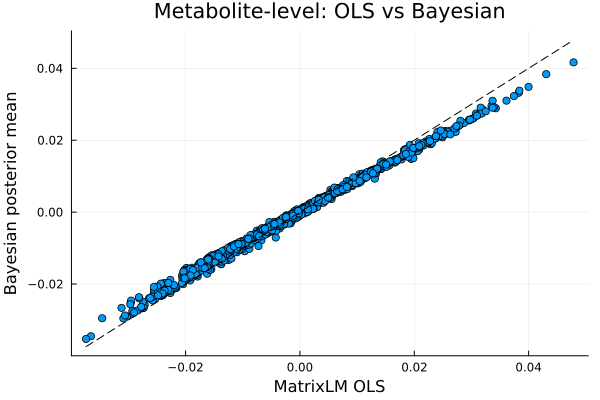

In [63]:
scatter(cmp_df_db.mlm_est_db, cmp_df_db.mean,
        xlabel="MatrixLM OLS", ylabel="Bayesian posterior mean",
        title="Metabolite-level: OLS vs Bayesian",legend=false)
plot!([minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)],
      [minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)], l=:dash, c=:black)

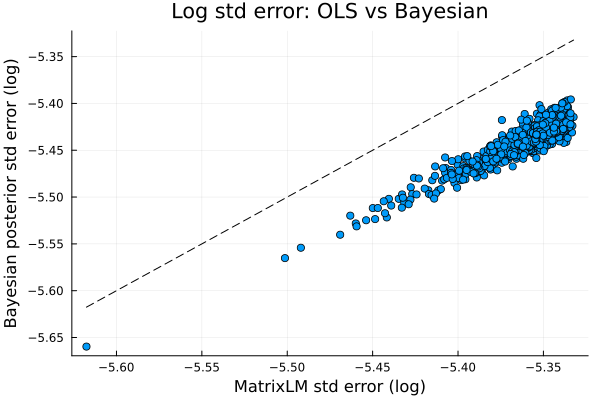

In [64]:
scatter(log.(cmp_df_db.mlm_se_db), log.(cmp_df_db.std_err),
        xlabel="MatrixLM std error (log)", ylabel="Bayesian posterior std error (log)",
        title="Log std error: OLS vs Bayesian", legend=false)
plot!([minimum(log.(cmp_df_db.mlm_se_db)), maximum(log.(cmp_df_db.mlm_se_db))],
      [minimum(log.(cmp_df_db.mlm_se_db)), maximum(log.(cmp_df_db.mlm_se_db))], l=:dash, c=:black)

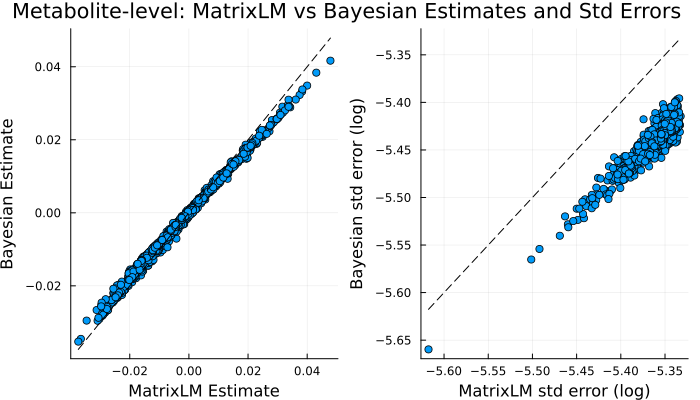

In [65]:
using Plots
gr()  

p1 = scatter(
    cmp_df_db.mlm_est_db, cmp_df_db.mean,
    xlabel = "MatrixLM Estimate",
    ylabel = "Bayesian Estimate",
    title  = "                                           Metabolite-level: MatrixLM vs Bayesian Estimates and Std Errors",
    legend = false
)
plot!(
    p1,
    [minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)],
    [minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)],
    l = :dash, c = :black
)

p2 = scatter(
    log.(cmp_df_db.mlm_se_db), log.(cmp_df_db.std_err),
    xlabel = "MatrixLM std error (log)",
    ylabel = "Bayesian std error (log)",
    title  = "",
    legend = false
)
plot!(
    p2,
    [minimum(log.(cmp_df_db.mlm_se_db)), maximum(log.(cmp_df_db.mlm_se_db))],
    [minimum(log.(cmp_df_db.mlm_se_db)), maximum(log.(cmp_df_db.mlm_se_db))],
    l = :dash, c = :black
)

# Combine side by side
plot(p1, p2, layout = (1, 2), size = (700, 400))

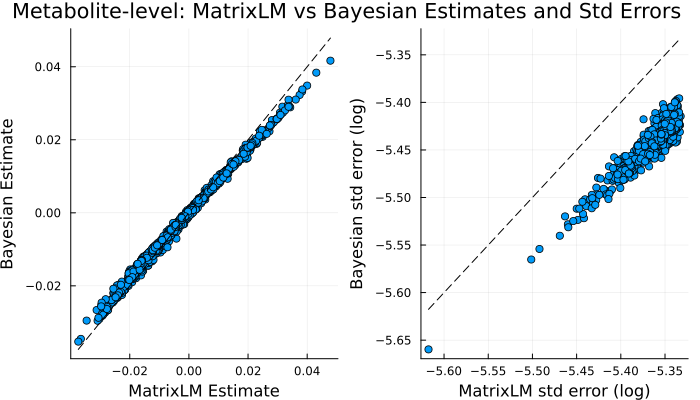

In [66]:
p = plot(p1, p2, layout = (1, 2), size = (700, 400))
#savefig(p, "matrixlm_vs_bayes_copd_one.pdf")

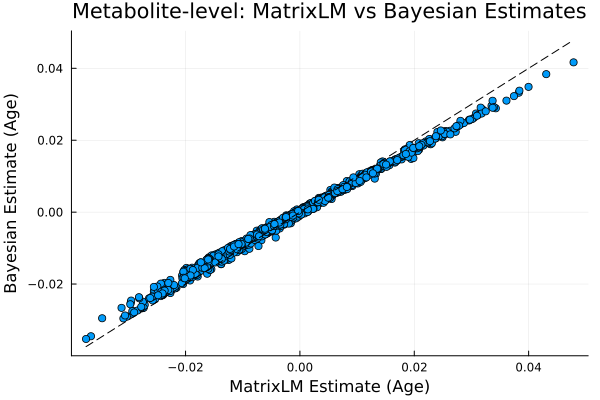

In [67]:
p3 = scatter(cmp_df_db.mlm_est_db, cmp_df_db.mean,
        xlabel="MatrixLM Estimate (Age)", ylabel="Bayesian Estimate (Age)",
        title="Metabolite-level: MatrixLM vs Bayesian Estimates",legend=false)
plot!([minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)],
      [minimum(cmp_df_db.mlm_est_db), maximum(cmp_df_db.mlm_est_db)], l=:dash, c=:black)

In [68]:
#savefig(p3, "matrixlm_vs_bayes_copd_est.pdf")